In [481]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Lasso, Ridge , LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
np.random.seed(1)
%matplotlib inline

In [405]:
df = pd.read_csv('insurance.csv')

In [406]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Data preprocessing

In [407]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [408]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Check missed data

In [409]:
df.isna().sum() #no missed data

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Check unique values of sex and its distribution

In [410]:
df['sex'].value_counts() #

male      676
female    662
Name: sex, dtype: int64

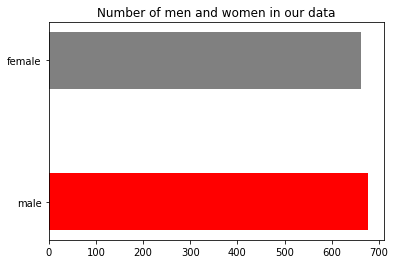

In [411]:
plt.barh(['male','female'],df['sex'].value_counts().values,height=0.4,color=['red','grey']);
plt.title('Number of men and women in our data');

Check number of children (it's impossible to have <0 or some high value) and its distribution. We can see that we have just a few rows with 4 and 5. So we can combine them with 3 and make it categorical feture (0,1,2,3+).

In [412]:
df['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

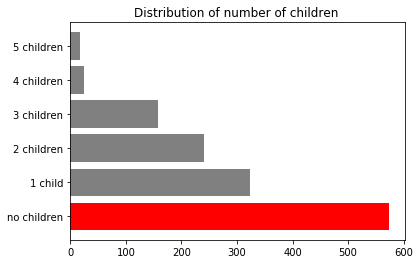

In [413]:
children = ['no children','1 child','2 children','3 children','4 children','5 children']
colors = ['grey']*6
colors[0] = 'r'
plt.barh(children,df['children'].value_counts().values,color=colors)
plt.title('Distribution of number of children ');

Check unique values of smoker and its distribution

In [414]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

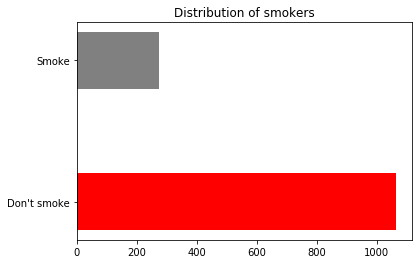

In [415]:
plt.barh(['Don\'t smoke','Smoke'],df['smoker'].value_counts().values,height=0.4,color=['red','grey'])
plt.title('Distribution of smokers');

Check unique values of region and its distribution

In [416]:
df['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

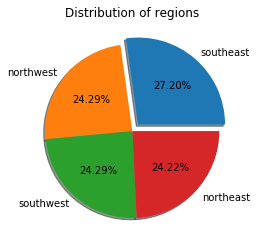

In [417]:
plt.pie(df['region'].value_counts().values, 
        labels=df['region'].value_counts().index,
        autopct='%1.2f%%',
        shadow=True,
        explode=(0.1,0,0,0));
plt.title('Distribution of regions');

Check some statistics in bmi and age and look for outliers

In [418]:
df['bmi'].describe()

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64

In [419]:
df['age'].describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

Look at bmi and age statistics

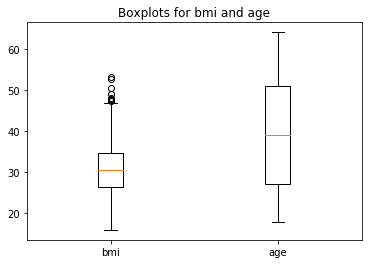

In [420]:
plt.boxplot([df['bmi'].values,df['age'].values],labels=['bmi','age']);
plt.title('Boxplots for bmi and age');

Based on our boxplot and hist for bmi we can see outliers with values more than 47. 

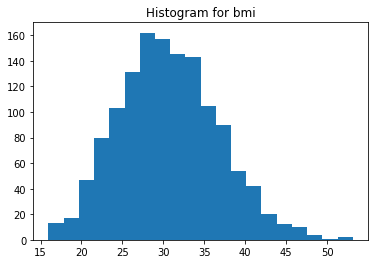

In [421]:
plt.hist(df['bmi'],bins=20);
plt.title('Histogram for bmi');

Look at the distribution of charges. We can see right skew here with heavy right tail.

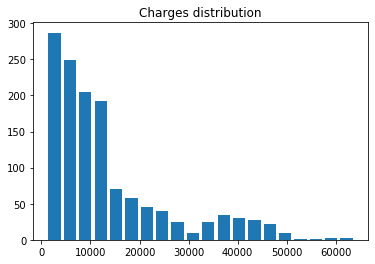

In [422]:
plt.hist(df['charges'],bins=20,histtype='bar',rwidth=0.8)
plt.title('Charges distribution');

In the plots below we can see that smokers in general have greater charges. Also we see age/bmi and charges are correlated.

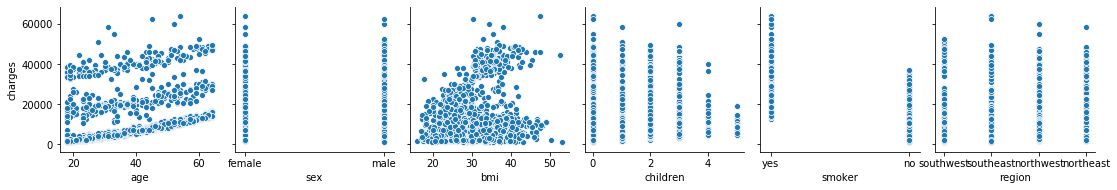

In [423]:
sns.pairplot(df,x_vars=['age','sex','bmi','children','smoker','region'],y_vars='charges',aspect=1);

From the correlation table we can see that number of children and sex are not correlated with other features but smoke, age and bmi are correlated with our target variable. So let's look closer at this correlation.

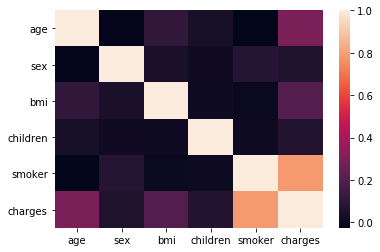

In [424]:
df['smoker'] = pd.get_dummies(df['smoker'],drop_first=True)
df['sex'] = pd.get_dummies(df['sex'],drop_first=True)
sns.heatmap(df.corr());

There are 2 plots. On the first we have boxplots for female and male who smokes and on the second one for not smokers. We can see that in general smokers median charges are higher than for people who doesn't smoke and there are no big difference between males and females have similar min/max values and interquartile range. Also we can see that people who doesn't smoke have charges more than 22 000 only in outliers.

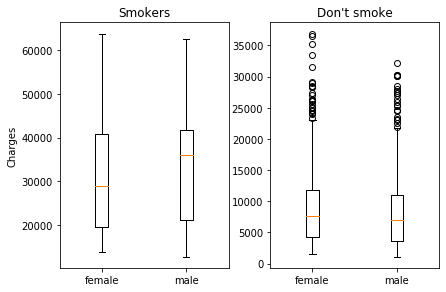

In [425]:
fig,axes = plt.subplots(nrows=1, ncols=2)
plt.tight_layout()

axes[0].boxplot([df.loc[(df['sex'] == 0) & (df['smoker']==1)]['charges'],
                 df.loc[(df['sex'] == 1) & (df['smoker']==1) ]['charges']],
                    labels=['female','male'])
axes[0].set_title('Smokers')
axes[0].set_ylabel('Charges');

axes[1].boxplot([df.loc[(df['sex'] == 0) & (df['smoker']==0)]['charges'],
                 df.loc[(df['sex'] == 1) & (df['smoker']==0) ]['charges']],
                    labels=['female','male'])
axes[1].set_title('Don\'t smoke')
axes[0].set_ylabel('Charges');

Here we can see dependency between age and charges. Also we can see that people who smoke has higher charges than people who doesn't smoke with the same age. We can say that the equation that describes this dependency has higher intersept for people who smokes but they have the same slope.

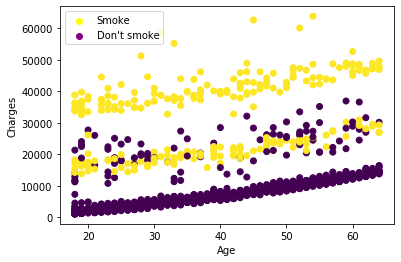

In [426]:
plt.scatter([],[],c='yellow',label='Smoke')
plt.scatter([],[],c='purple',label='Don\'t smoke')
plt.scatter(df['age'],df['charges'],c=df['smoker'])
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend();

Here we can see dependency between bmi for smokers and charges but we can't see high dependency  between bmi for not smokers and charges.

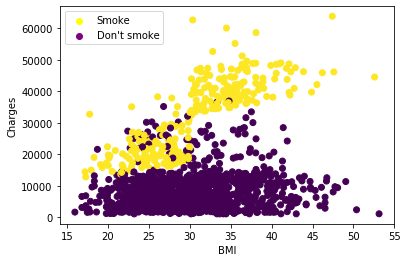

In [427]:
plt.scatter([],[],c='yellow',label='Smoke')
plt.scatter([],[],c='purple',label='Don\'t smoke')
plt.scatter(df['bmi'],df['charges'],c=df['smoker'])
plt.legend();
plt.xlabel('BMI')
plt.ylabel('Charges');

# Feature engineering

In [452]:
data = df.copy()

region = pd.get_dummies(data['region'],drop_first=True)
data = pd.concat([data,region],axis=1)
data.drop('region',axis=1,inplace=True)

data.loc[data['children']>=3,'children'] = 3
children = pd.get_dummies(data['children'],drop_first=True)
data = pd.concat([data,children],axis=1)
data.drop('children',axis=1,inplace=True)
data.head(15)

,age,sex,bmi,smoker,charges,northwest,southeast,southwest,1,2,3
0,19,0,27.900,1,16884.92400,0,0,1,0,0,0
1,18,1,33.770,0,1725.55230,0,1,0,1,0,0
2,28,1,33.000,0,4449.46200,0,1,0,0,0,1
3,33,1,22.705,0,21984.47061,1,0,0,0,0,0
4,32,1,28.880,0,3866.85520,1,0,0,0,0,0
5,31,0,25.740,0,3756.62160,0,1,0,0,0,0
6,46,0,33.440,0,8240.58960,0,1,0,1,0,0
7,37,0,27.740,0,7281.50560,1,0,0,0,0,1
8,37,1,29.830,0,6406.41070,0,0,0,0,1,0
9,60,0,25.840,0,28923.13692,1,0,0,0,0,0


In [453]:
scale = MinMaxScaler()
polynom = PolynomialFeatures(degree=2)

Split our data into train (for feating) and test (for evaluating) sets 

In [454]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['charges'],axis=1),
                                                    data[['charges']],
                                                    test_size=0.20, 
                                                    random_state=0)

Use MinMaxScaler on our numerical features (age,bmi,smoker) cause we want them to be in one distribution. As a result all values will lie between 0 and 1 

In [455]:
X_train[['age','bmi','smoker']] = scale.fit_transform(X_train[['age','bmi','smoker']])

In [456]:
X_test[['age','bmi','smoker']] = scale.transform(X_test[['age','bmi','smoker']])

In [457]:
import statsmodels.regression.linear_model as lr

Make model using statsmodels to answer the question of importance of different features

In [458]:
ols_model = lr.OLS(endog=y_train, exog=X_train).fit()

In [459]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                charges   R-squared (uncentered):                   0.881
Model:                            OLS   Adj. R-squared (uncentered):              0.880
Method:                 Least Squares   F-statistic:                              783.5
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                        0.00
Time:                        19:52:23   Log-Likelihood:                         -10854.
No. Observations:                1070   AIC:                                  2.173e+04
Df Residuals:                    1060   BIC:                                  2.178e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age         1.105e+04    584.021     18.915      0.000    9900.983    1.22e+04
sex         -281.8766    367.605     -0.767      0.443   -1003.193     439.440
bmi         1.047e+04    989.145     10.580      0.000    8524.444    1.24e+04
smoker      2.333e+04    465.756     50.095      0.000    2.24e+04    2.42e+04
northwest   -955.6289    499.197     -1.914      0.056   -1935.156      23.898
southeast  -1313.6935    533.501     -2.462      0.014   -2360.531    -266.856
southwest  -1340.9390    503.263     -2.664      0.008   -2328.443    -353.435
1            173.8392    467.039      0.372      0.710    -742.588    1090.266
2           1482.4128    525.008      2.824      0.005     452.240    2512.585
3            780.1586    570.690      1.367      0.172    -339.652    1899.970
==============================================================================
Omnibus:                      261.797   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              644.765
Skew:                           1.294   Prob(JB):                    9.79e-141
Kurtosis:                       5.786   Cond. No.                         6.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Predictor that has a low p-value is likely to be a meaningful  because changes in the predictor's value are related to changes in the response variable. So below we can see p-values of our predictors and can make conclusion that smoker,age and bmi have strong impact on the results we get. 

In [460]:
ols_model.pvalues.sort_values()

smoker       9.911550e-282
age           5.556900e-69
bmi           6.130485e-25
2             4.837659e-03
southwest     7.827544e-03
southeast     1.395916e-02
northwest     5.584684e-02
3             1.719014e-01
sex           4.433763e-01
1             7.098069e-01
dtype: float64

### Predictors with higher absolute coefficients have higher impact on the result of our model. So we can see again that smoker, age and bmi are the most important features and they have the highest impact in our model.

In [479]:
np.abs(ols_model.params).sort_values(ascending=False)

smoker       23331.969423
age          11046.951676
bmi          10465.347822
2             1482.412753
southwest     1340.939013
southeast     1313.693516
northwest      955.628926
3              780.158567
sex            281.876577
1              173.839213
dtype: float64

### The R-2 score of the model above. It's 0.80 and if to take into account that good results lie between 0 and 1, we have good results and how to explain it. One of the way of interpretation of R-2 score is the part of the variety our model explains in the whole variety of answers so we can say this model explains 80% of variety of our data. 

In [461]:
r2_score(y_test, ols_model.predict(X_test))

0.7973631353742893

### The MAE of the model above. It's 4000 and we can interprete as a mistake +- 4000 in general for object

In [462]:
mean_absolute_error(y_test, ols_model.predict(X_test))

3946.6325282672988

Let's make some new features to add nonlinearity to obtain better results.

In [463]:
X_tr = polynom.fit_transform(X_train[['age','bmi','smoker']])
X_ts = polynom.fit_transform(X_test[['age','bmi','smoker']])

In [464]:
X_train = np.concatenate((X_train.drop(['age','bmi','smoker'],axis=1).values,X_tr),axis=1)
X_test = np.concatenate((X_test.drop(['age','bmi','smoker'],axis=1).values,X_ts),axis=1)

In [465]:
new_ols_model = lr.OLS(endog=y_train, exog=X_train).fit()

In [466]:
new_ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     352.9
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:52:33   Log-Likelihood:                -10606.
No. Observations:                1070   AIC:                         2.124e+04
Df Residuals:                    1054   BIC:                         2.132e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -422.9960    302.237     -1.400      0.162   -1016.050     170.058
x2          -601.9672    439.866     -1.369      0.171   -1465.080     261.146
x3         -1006.0623    439.767     -2.288      0.022   -1868.981    -143.143
x4         -1224.8920    434.193     -2.821      0.005   -2076.873    -372.911
x5           890.0390    399.967      2.225      0.026     105.216    1674.862
x6          2091.2305    443.402      4.716      0.000    1221.180    2961.281
x7          1767.0796    473.044      3.736      0.000     838.865    2695.294
const       2072.4039    957.238      2.165      0.031     194.095    3950.712
x8          4547.8186   2210.832      2.057      0.040     209.686    8885.951
x9          1.067e+04   3668.573      2.910      0.004    3475.974    1.79e+04
x10         1443.2300    529.503      2.726      0.007     404.230    2482.230
x11         6503.1664   1997.894      3.255      0.001    2582.864    1.04e+04
x12         3432.7139   2993.400      1.147      0.252   -2440.986    9306.414
x13           85.6372   1246.916      0.069      0.945   -2361.084    2532.358
x14        -1.368e+04   4000.695     -3.420      0.001   -2.15e+04   -5830.522
x15         5.274e+04   2194.739     24.029      0.000    4.84e+04     5.7e+04
x16         1443.2300    529.503      2.726      0.007     404.230    2482.230
==============================================================================
Omnibus:                      588.708   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3643.528
Skew:                           2.569   Prob(JB):                         0.00
Kurtosis:                      10.439   Cond. No.                     1.80e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.55e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [467]:
new_ols_model.pvalues.sort_values()

x15      4.275387e-102
x6        2.723796e-06
x7        1.973426e-04
x14       6.511590e-04
x11       1.169954e-03
x9        3.693573e-03
x4        4.876115e-03
x10       6.524211e-03
x16       6.524211e-03
x3        2.235147e-02
x5        2.627345e-02
const     3.061282e-02
x8        3.992590e-02
x1        1.619420e-01
x2        1.714400e-01
x12       2.517407e-01
x13       9.452580e-01
dtype: float64

In [478]:
np.abs(new_ols_model.params).sort_values(ascending=False)

x15      52738.322950
x14      13680.755569
x9       10674.510838
x11       6503.166373
x8        4547.818593
x12       3432.713862
x6        2091.230542
const     2072.403912
x7        1767.079609
x10       1443.230015
x16       1443.230015
x4        1224.891981
x3        1006.062287
x5         890.038970
x2         601.967172
x1         422.995971
x13         85.637223
dtype: float64

### Here we can see that we improved our results from 0.8 to 0.88

In [468]:
r2_score(y_test, new_ols_model.predict(X_test))

0.8855189858726291

### And MAE was improved from 4000 to 2800

In [469]:
mean_absolute_error(y_test, new_ols_model.predict(X_test))

2815.1934345532645

# Random Forest

In [508]:
forest = RandomForestRegressor(n_estimators=150,random_state=1,max_depth=6)
forest.fit(X_train,y_train)
print('R2 score for test data {}'.format(forest.score(X_test,y_test)))
print('R2 score for train data {}'.format(forest.score(X_train,y_train)))
print('Mean absolute error for test data {}'.format(mean_absolute_error(y_test,forest.predict(X_test))))
print('Mean absolute error for train data {}'.format(mean_absolute_error(y_train,forest.predict(X_train))))

C:\Users\Windows10x64\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


R2 score for test data 0.8961816761789606
R2 score for train data 0.8882686790474139
Mean absolute error for test data 2378.473899683231
Mean absolute error for train data 2201.4971510685955


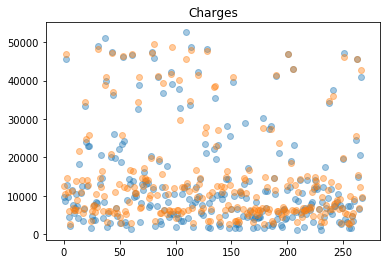

In [511]:
plt.scatter(np.arange(len(y_test)), y_test,alpha=0.4);
plt.scatter(np.arange(len(y_test)), forest.predict(X_test),alpha=0.4);
plt.title('Charges');

# XGBRegressor model

In [520]:
xgb_model = XGBRegressor(n_estimators=8)
xgb_model.fit(X_train, y_train)
print('R2 score for test data {}'.format(xgb_model.score(X_test,y_test)))
print('R2 score for train data {}'.format(xgb_model.score(X_train,y_train)))
print('Mean absolute error for test data {}'.format(mean_absolute_error(y_test,xgb_model.predict(X_test))))
print('Mean absolute error for train data {}'.format(mean_absolute_error(y_train,xgb_model.predict(X_train))))

R2 score for test data 0.8784510711426791
R2 score for train data 0.8842222648561235
Mean absolute error for test data 2428.7349771735658
Mean absolute error for train data 2082.8225227224375


The best result was obtained with random forest it's r2 score equals 0.89 also it was not overfitted because the scores for train and test data are similar.

# Conclusion

Our model gives us good results (R2 score = 0.89 and MAE = 2400) if to take into account that we have only 1338 rows and several features which are not highly correlated with the target feature. To obtain better results in predicting the charges we need more features (like alcholol, drugs, sugar level and etc) and more data. Also one of the main features (BMI) could cause some problems for our model because it uses only weight and height and we don't know anything about the percent of fat and muscles in the body. 